In [7]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

Using TensorFlow backend.


In [11]:
train = pd.read_csv("C:/Users/Ayushi Agarwal/Desktop/Projects/character recognition/input/emnist/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("C:/Users/Ayushi Agarwal/Desktop/Projects/character recognition/input/emnist/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("C:/Users/Ayushi Agarwal/Desktop/Projects/character recognition/input/emnist/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [12]:
# Constants
HEIGHT = 28
WIDTH = 28

In [13]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [14]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [15]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [16]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [17]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

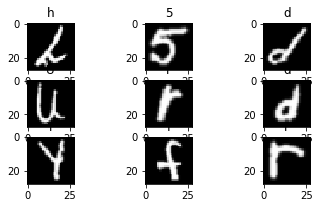

In [18]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [19]:
# number of classes
num_classes = train_y.nunique()

In [20]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [21]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [22]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

In [24]:
# Building model
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Train on 101519 samples, validate on 11280 samples
Epoch 1/10
101519/101519 [==============================] - 562s 6ms/step - loss: 1.5465 - acc: 0.5621 - val_loss: 0.5653 - val_acc: 0.8152
Epoch 2/10
101519/101519 [==============================] - 627s 6ms/step - loss: 0.7519 - acc: 0.7623 - val_loss: 0.4591 - val_acc: 0.8414
Epoch 3/10
101519/101519 [==============================] - 672s 7ms/step - loss: 0.6198 - acc: 0.7993 - val_loss: 0.4113 - val_acc: 0.8550
Epoch 4/10
101519/101519 [==============================] - 873s 9ms/step - loss: 0.5533 - acc: 0.8185 - val_loss: 0.3868 - val_acc: 0.8590
Epoch 5/10
101519/101519 [==============================] - 885s 9ms/step - loss: 0.5091 - acc: 0.8295 - val_loss: 0.3729 - val_acc: 0.8661
Epoch 6/10
101519/101519 [==============================] - 909s 9ms/step - loss: 0.4780 - acc: 0.8387 - val_loss: 0.3608 - val_acc: 0.8657
Epoch 7/10
101519/101519 [==============================] - 914s 9ms/step - loss: 0.4531 - acc: 0.8456 - val_

In [27]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

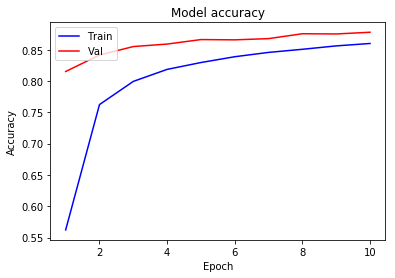

In [29]:
plotgraph(epochs, acc, val_acc)

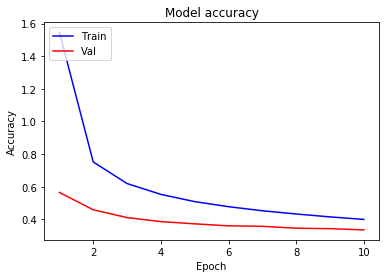

In [30]:
#loss curve
plotgraph(epochs, loss, val_loss)

In [31]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3558610190536197
Test accuracy: 0.8789297303111447


In [32]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [33]:
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

In [34]:
cm

array([[352,   0,   0, ...,   0,   0,   0],
       [172, 163,   0, ...,   0,   0,   0],
       [  8,   0, 347, ...,   0,   0,   0],
       ...,
       [110,   0,   0, ..., 148,   0,   0],
       [  5,   0,   0, ...,   0, 373,   1],
       [  9,   0,   0, ...,   0,   5, 359]], dtype=int64)